In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact
from climada.entity import ImpactFunc,ImpactFuncSet


from os import mkdir, remove, rmdir


In [3]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

In [4]:
print(cmip6vars)

{'sfcWindmax': 'SWM', 'sfcWind': 'SW', 'psl': 'SLP', 'tas': 'TAS', 'ua': 'UA', 'ta': 'TA', 'tos': 'TOS'}


In [5]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
bn = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
bn_proc = make_fn(processings,bn)



# Exposure

In [6]:
#import exposure data (already preprocessed)
from climada.entity import Exposures
from climada import CONFIG
results = CONFIG.local_data.save_dir.dir()
exp = Exposures.from_hdf5(results.joinpath(('exposures/exp_crpd_EU_600.h5')))
exp.check()


/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<GeoAxesSubplot:title={'center':"LitPop Exposure for ['Andorra', 'Albania', 'Austria', 'Belgium',\n'Bulgaria', 'Belarus', 'Czech Republic', 'Germany', 'Denmark',\n'Estonia', 'Finland', 'France', 'Greece', 'Hungary', 'Iceland',\n'Italy', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Latvia',\n'Malta', 'Kingdom of the Netherlands', 'Norway', 'Poland', 'Portugal',\n'Romania', 'Sweden', 'Slovenia', 'Slovakia', 'San Marino', 'Ukraine',\n'Bosnia and Herzegovina', 'Croatia', 'Moldova', 'Monaco',\n'Montenegro', 'Serbia', 'Spain', 'Switzerland', 'United Kingdom',\n'Ireland', 'Republic of Moldova'] at 600 as, year: 2018, financial\nmode: pc, exp: (1, 1), admin1_calc: False"}>

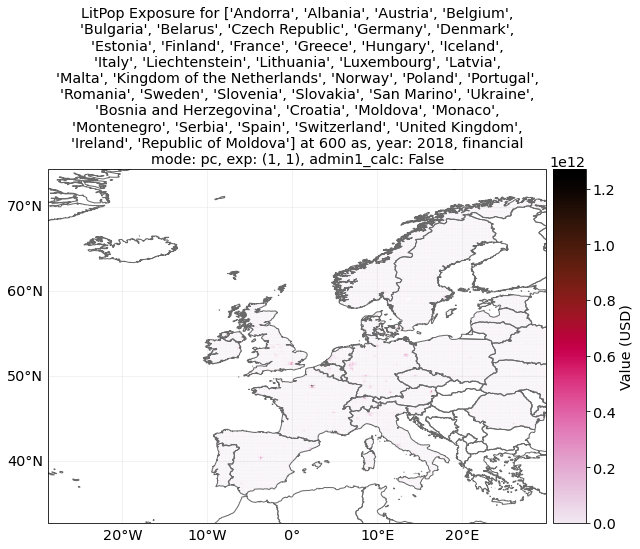

In [7]:
## subselect exposure according to the countries in EMDAT
ctrEMDAT = ['United Kingdom','Ireland','Belgium', 'Switzerland', 'Spain', 'France', 'Kingdom of the Netherlands',
            'Germany', 'Denmark', 'Ireland', 'Lithuania', 'Latvia', 'Poland','Sweden', 'Austria', 'Czech Republic', 
            'Estonia', 'Norway', 'Belarus', 'Slovenia','Ukraine', 'Romania', 'Italy', 'Luxembourg', 'Portugal']

## get region ids
ltpop_info = pd.read_csv('/home/lseverino/MT/metadata/LitPop_metadata_countries_v1_2.csv',sep=',')

#select exposure
#sel exposure according to region
count_ids = ltpop_info['region_id'].where(ltpop_info['country_name'].isin(ctrEMDAT)).dropna().tolist()
if 'United Kingdom' in ctrEMDAT: #manually add UK
    count_ids.append(826)
if 'Kingdom of the Netherlands' in ctrEMDAT:
    count_ids.append(528)
if 'Austria' in ctrEMDAT:
    count_ids.append(40)
if 'Moldova' in ctrEMDAT:
    count_ids.append(498)
if 'Czech Republic' in ctrEMDAT:
    count_ids.append(203)
if 'Macedonia' in ctrEMDAT:
    count_ids.append(807)
    
sel_exp = cp.deepcopy(exp)
sel_exp.gdf = sel_exp.gdf.where(sel_exp.gdf['region_id'].isin(count_ids)).dropna()
sel_exp.plot_hexbin(pop_name=False)

# Impact functions

### Original

In [8]:
# Implement impact function cubic excess from Prahl 2015 
from climada.entity import ImpactFunc
imp_fun_cub = ImpactFunc()
imp_fun_cub.haz_type = 'WS'
imp_fun_cub.name = 'Cubic excess-over-threshold'
# provide unit of the hazard intensity
imp_fun_cub.intensity_unit = 'm/s'
# provide values for the hazard intensity, mdd, and paa
#imp_fun_cub.intensity = np.linspace(0, 100, num=1500)
#mdd = imp_fun_cub.intensity**3
#mdd_capped = np.where(mdd>1,1,mdd)
#imp_fun_cub.mdd = mdd_capped
imp_fun_cub.intensity = np.linspace(0, 1, num=20)
imp_fun_cub.mdd = imp_fun_cub.intensity**3
imp_fun_cub.intensity = np.append(imp_fun_cub.intensity, [100])
imp_fun_cub.mdd = np.append(imp_fun_cub.mdd, [1])
imp_fun_cub.paa = np.ones(imp_fun_cub.intensity.shape)
# check if the all the attributes are set correctly
imp_fun_cub.id = 1
imp_fun_cub.check()


2022-08-08 17:01:23,176 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


In [9]:
## impact function
#original
from climada.entity.impact_funcs import storm_europe, ImpfTropCyclone

#Get  Schwierz Impf
impFunc_schw = storm_europe.ImpfStormEurope.from_schwierz()

#Get Emanuel impf
impFunc_emanuel_usa = ImpfTropCyclone.from_emanuel_usa()
# plot the impact function
impFunc_emanuel_usa.id = 2
impFunc_emanuel_usa.haz_type = 'WS'
impFunc_emanuel_usa.check()

impFunc_schw.id = 3
impFunc_schw.haz_type = 'WS'
impFunc_schw.check()

2022-08-08 17:01:23,209 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


2022-08-08 17:01:23,214 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-08-08 17:01:23,215 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-08-08 17:01:23,216 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-08-08 17:01:23,216 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-08-08 17:01:23,216 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or pa

(0.0, 2.0)

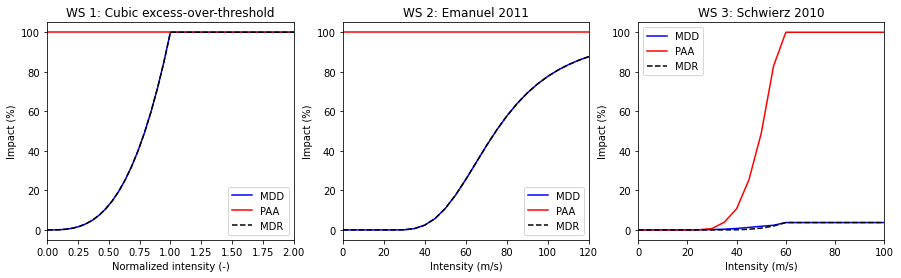

In [10]:
# generate 1 impf set for all functions
from climada.entity import ImpactFuncSet
impf_list = [imp_fun_cub,impFunc_emanuel_usa,impFunc_schw]
impf_namelist = []
impf_set = ImpactFuncSet()
for impf in impf_list:
    impfname = impf.name
    impf_namelist.append(impfname)
    impf_set.append(impf)
    impf_set.check()

axs = impf_set.plot()
fig = axs[0].get_figure()
fig.set_figwidth(15)
axs[0].set_xlabel('Normalized intensity (-)')
axs[0].set_xlim((0,2))
#axs[1].set_xlabel('Excess-over-threshold intensity (m/s)')
#axs[1].set_xlim((0,20))

### Excess-over-threshold

In [11]:
## impact function
#scaled to work with excess over threshold
from climada.entity.impact_funcs import storm_europe, ImpfTropCyclone

#Get and calibrate Schwierz Impf
impFunc_schw_diff = storm_europe.ImpfStormEurope.from_schwierz()
impFunc_schw_diff.intensity = np.array([0,  5,  10,  15,  20,  25,  30,  35,  40,  60, 80])
impFunc_schw_diff.mdd = np.array([0., 0.001, 0.00177515, 0.00367253, 0.00749977, 0.01263556, 0.01849639, 
                             0.02370487, 0.037253,0.037253  , 0.037253  ])
impFunc_schw_diff.paa = np.array([0., 0.001, 0.00676, 0.03921, 0.10707, 0.25357,0.48869, 0.82907, 1., 1., 1.])

impFunc_schw_diff.id = 3
impFunc_schw_diff.haz_type = 'WS'
impFunc_schw_diff.check()

#Emanuel
#impFunc_emanuel_usa = ImpfTropCyclone.from_emanuel_usa(v_thresh=0, v_half=15)

#Get and calibrate Emanuel impf
impFunc_emanuel_usa_diff = ImpfTropCyclone.from_emanuel_usa(v_thresh=0, v_half=40)
# plot the impact function
impFunc_emanuel_usa_diff.id = 2
impFunc_emanuel_usa_diff.haz_type = 'WS'
impFunc_emanuel_usa.check()


2022-08-08 17:01:23,669 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


2022-08-08 17:01:23,683 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-08-08 17:01:23,684 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-08-08 17:01:23,684 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-08-08 17:01:23,684 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2022-08-08 17:01:23,685 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or pa

Text(0.5, 0, 'Excess-over-threshold intensity (m/s)')

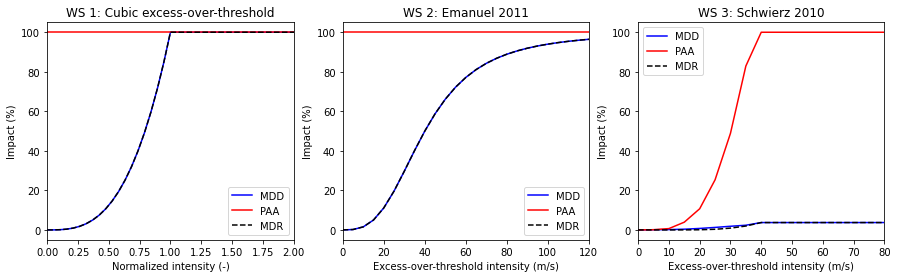

In [12]:
# generate 1 impf set for all functions
from climada.entity import ImpactFuncSet
impf_list = [imp_fun_cub,impFunc_emanuel_usa_diff,impFunc_schw_diff]
impf_namelist = []
impf_set_diff = ImpactFuncSet()
for impf in impf_list:
    impfname = impf.name
    impf_namelist.append(impfname)
    impf_set_diff.append(impf)
    impf_set_diff.check()

axs = impf_set_diff.plot()
fig = axs[0].get_figure()
fig.set_figwidth(15)
axs[0].set_xlabel('Normalized intensity (-)')
axs[0].set_xlim((0,2))
axs[1].set_xlabel('Excess-over-threshold intensity (m/s)')
#axs[1].set_xlim((0,20))
axs[2].set_xlabel('Excess-over-threshold intensity (m/s)')
#axs[2].set_xlim((0,20))

## Plot impfs

Text(0.5, 0, 'Excess-over-threshold intensity (m/s)')

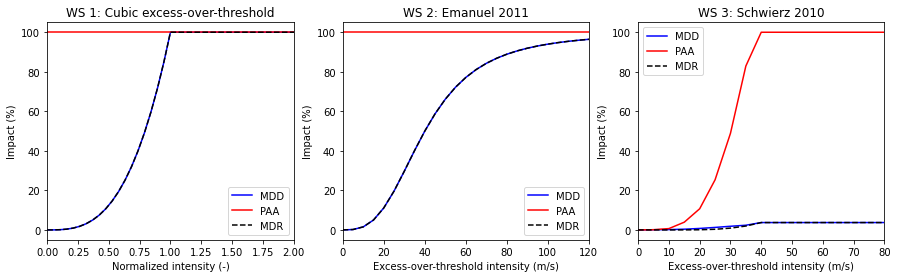

In [14]:
axs = impf_set_diff.plot()
fig = axs[0].get_figure()
fig.set_figwidth(15)
axs[0].set_xlabel('Normalized intensity (-)')
axs[0].set_xlim((0,2))
axs[1].set_xlabel('Excess-over-threshold intensity (m/s)')
#axs[1].set_xlim((0,20))
axs[2].set_xlabel('Excess-over-threshold intensity (m/s)')
#axs[2].set_xlim((0,20))

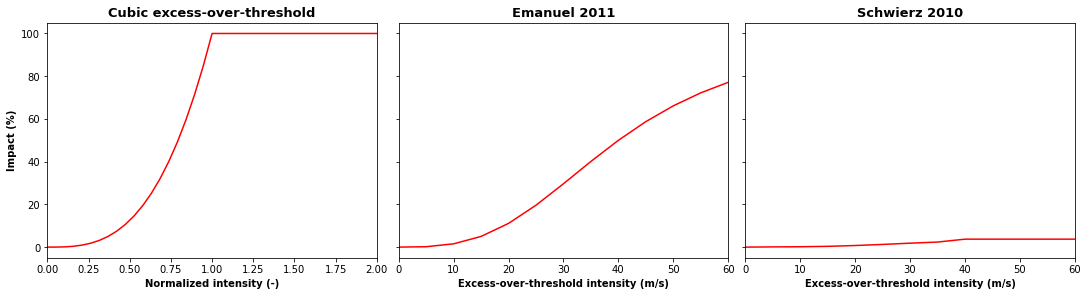

In [51]:
impf_set_plot = impf_set_diff
nimpf = len(impf_set_plot.get_func()['WS'])
xlabels = ['Normalized intensity (-)','Excess-over-threshold intensity (m/s)','Excess-over-threshold intensity (m/s)']
xlims = [(0,2),(0,60),(0,60)]
ftsize = 10
saving = True
savelocation="results/figures/Impacts/Impf/"
savefileName = 'impf_set_diff.png'
fig = plt.figure(figsize=(5*nimpf,4),constrained_layout=True)
axs = fig.subplots(nrows=1,ncols=3,sharey=True).flat
for impfid,impf in impf_set_plot.get_func()['WS'].items():
    ax = axs[impfid-1]
    xlim = xlims[impfid-1]
    xlab = xlabels[impfid-1]
    ax.plot(impf.intensity,100*impf.mdd,color='r',linewidth=1.5)
    ax.set_xlabel(xlab,fontsize=ftsize,fontweight='bold')
    ax.set_title(impf.name,fontsize=ftsize+3,fontweight='bold')
    ax.set_xlim(xlim)
axs[0].set_ylabel('Impact (%)',fontsize=ftsize,fontweight='bold')
if saving:
    fig.savefig(savelocation+savefileName,transparent=False,bbox_inches='tight')

In [29]:
axs

In [24]:
impf.mdd

array([0.        , 0.001     , 0.00177515, 0.00367253, 0.00749977,
       0.01263556, 0.01849639, 0.02370487, 0.037253  , 0.037253  ,
       0.037253  ])

In [17]:
impf_set_diff.get_func()

{'WS': {1: <climada.entity.impact_funcs.base.ImpactFunc at 0x7f025bd56f70>,
  2: <climada.entity.impact_funcs.trop_cyclone.ImpfTropCyclone at 0x7f025ba6a880>,
  3: <climada.entity.impact_funcs.storm_europe.ImpfStormEurope at 0x7f025ba6a310>}}

# Simple calibration

In [15]:
#select climate models, used scenarios (historical, ssp585,...), impact functions and calibration type
modlist = modlist_ssp585 + modlist_allscen
modlist = modlist
#impf_used = impf_namelist
scen_used= ['historical']
pastname = 'historical'
timeres='day'
nmems = 3
caltype = 'AAI_EMDAT'

In [16]:
#initiate df to save results
metrics = ["AAI_agg","45 yr impact","90 yr impact"]
itercol = [scen_used,metrics]
col_idx = pd.MultiIndex.from_product(itercol,names=["scenario","metric"])
iterrows = [modlist,range(nmems)]
row_idx= pd.MultiIndex.from_product(iterrows,names=["model","member"])


In [ ]:
##main calculation cell.
#Loop over impact functions, scenarios, models and model members
#Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
#Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.
stack = True
savehaz = False
saveimpmat = True
saveimpcsv = False
savestats = True
flt_imp = True #need to enables impact matrices
flt = 100E6
it = 0 #iteration count
df_list = []
impf_keys = []

for impf in impf_used:
    #initiate df
    if stack:
        res_df = pd.DataFrame(columns=col_idx,index=modlist)
        nmems=1
    else:
        res_df = pd.DataFrame(columns=col_idx,index=row_idx)
    
    # get impfset
    impf_set = impf_dict[impf]


    for scen in scen_used:
        for modid, modname in enumerate(modlist):
            #read netcdf
            fn = make_fn([modname],bn,filetype=".nc")
            ncdf = xr.open_dataset(pathinvar+fn)
            ncdfw = ncdf[[pastname,scen]]
            latres, lonres = get_lat_lon_res(ncdf)
            latout = ncdf.lat
            lonout = ncdf.lon
            #select number of members to be considered
            if stack:
                nmems=1
            else:
                nmems = len(ncdf.member)
                
            #apply gust factor
            gust_ds = gst_fact*ncdfw
            
            # get names
            impf_namesht = impf_sht_names[impf]
            pp_funcname = str(pp_func_dic1[impf]).split(" ")[1]
            savenamehaz = make_fn([pp_funcname],bn_proc)
            savenameimp = make_fn([impf_namesht,caltype],bn_proc)
            
            #calibrate impf
            if caltype!='nocal':
                calname = make_fn(["cal",caltype],bn_proc+'_allmods',filetype=".csv")
                paramspath = pathcal+calname
                param = pd.read_csv(paramspath,header=[0,1,2],index_col=0).loc[modname,(impf_namesht,"historical","AAI_agg")]
                impf_set = tune_impf(impf_set,param,modname,plot=False)
                if_id = 1 #select calibrated impf
            

            #iterate over the members
            for imem in range(nmems):
                #preprocess fields
                if stack:
                    mem_da = gust_ds
                else: 
                    mem_da = gust_ds.sel(member=imem)
            
                preprocess_func = pp_func_dic1[impf]
                gust_pp = preprocess_func(mem_da,qt,cutarea=cut,timeres=timeres,pastname=pastname,futname=scen,stack=stack)
                if scen != 'historical':
                    gust_pp_sel = gust_pp[scen]
                else:
                    gust_pp_sel = gust_pp
                
                #prepare hazards centroids
                haz = set_centroids(gust_pp_sel,stack=stack,timeres=timeres,plot=False)
                if impf_namesht == 'CubEOT':
                    max_int =  haz.intensity.max()
                    if max_int >= 1:
                        print("*"*100+'\n\n'+' '*25+'/!\ max_int = '+str(max_int)+' for model '+modname+'\n\n'+"*"*100)
                
                
                # deepcopy exposure before assigning centroids
                exp_sel = cp.deepcopy(exp)
                # Exposures: rename column and assign id
                exp_sel.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
                exp_sel.gdf['impf_' + haz_type] = if_id
                
                ####### dummy exposure
                #exp_sel.gdf.value = 1000
                #test = 'stepexp' # step exposure


                #assign centroids
                #exp_sel.assign_centroids(haz,distance='approx',threshold=300)
                dist_th = np.sqrt((latres*100)**2 + (lonres*100)**2)
                exp_sel.assign_centroids(haz,distance='euclidean',threshold=dist_th)
                exp_sel.check()
                
                #compute impacts
                start_time = timer()
                imp = Impact()
                imp.calc(exp_sel, impf_set, haz, save_mat=saveimpmat) 
                print('Original: '+format(imp.aai_agg,'.2E'))
                if flt_imp:
                    imp_ae = imp.at_event
                    mask = np.where(imp_ae>flt)
                    imp_ae_flt = imp_ae[mask]
                    aai_agg_flt = np.sum(imp_ae_flt)*imp.frequency[0]
                    imp.aai_agg = aai_agg_flt
                    print('Computed: '+format(imp.aai_agg,'.2E'))
                time_delta_past = timer() - start_time
                print(time_delta_past)
    
                #save results
                if savestats:
                    #compute freq curves 
                    imp45 = imp.calc_freq_curve(return_per=45).impact 
                    imp90 = imp.calc_freq_curve(return_per=90).impact 
                    if stack:
                        res_df.loc[modname,(scen,"AAI_agg")] = imp.aai_agg
                        res_df.loc[modname,(scen,"45 yr impact")] = imp45
                        res_df.loc[modname,(scen,"90 yr impact")] = imp90
                    else: 
                        res_df.loc[(modname,imem),(scen,"AAI_agg")] = imp.aai_agg
                        res_df.loc[(modname,imem),(scen,"45 yr impact")] = imp45
                        res_df.loc[(modname,imem),(scen,"90 yr impact")] = imp90
                
                ##save files
                
                if stack:
                    simname = 'stacked'
                    savesubdir = 'stacked/'+scen+'/'
                else:
                    simname = 'nmem'+str(imem)
                    savesubdir = 'memsep/'+scen+'/'

                
                #save hazards
                if savehaz:
                    try:
                        haz.write_hdf5(pathhaz+savesubdir+make_fn(['haz',simname,scen,modname],savenamehaz,filetype='.h5'))
                    except FileNotFoundError:
                        mkdir(pathhaz+savesubdir)
                        haz.write_hdf5(pathhaz+savesubdir+make_fn(['haz',simname,scen,modname],savenamehaz,filetype='.h5'))
                #save impacts
                if saveimpcsv:
                    try:
                        #rmdir(pathimp+'impact csv/memsep/'+scen+"/")
                        #mkdir(pathimp+'impact csv/memsep/'+scen+"/")
                        imp.write_csv(pathimp+'impact csv/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.csv'))
                    except FileNotFoundError:
                        mkdir(pathimp+'impact csv/aggregated/'+savesubdir)
                        imp.write_csv(pathimp+'impact csv/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.csv'))
                if saveimpmat:
                    try:
                        #rmdir(pathimp+'impact matrices/'+savesubdir)
                        #mkdir(pathimp+'impact matrices/'+savesubdir)
                        imp.write_sparse_csr(pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.npz'))
                    except FileNotFoundError:
                        mkdir(pathimp+'impact matrices/aggregated/'+savesubdir)
                        imp.write_sparse_csr(pathimp+'impact matrices/aggregated/'+savesubdir+make_fn(['imp',simname,scen,modname],savenameimp,filetype='.npz'))
                #delete haz, imp and ep  objects
                #del haz
                #del imp
                #del exp_sel
        it = it+1       

    res_df = res_df.astype(np.float64)
    impf_keys.append(impf_namesht)
    df_list.append(res_df)

res_df_all = pd.concat(df_list,keys=impf_keys,axis=1,names=("Impf","scenario","metric"))

basenamemet_proc# Calibration
Type 1 calibration: do a modelwise calibration by scaling AAI_agg from the historical run on the yearly average impact from EMDAT.

In [30]:
aai_agg_emdat

3073582500.0

In [32]:
lst_bn = metvar+spaceres+["day"]+domain+season+["allmods"]
basenamemet = sep.join(lst_bn)
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)

caltype = "AAI_EMDAT_100mn"
calfn = make_fn(["cal",caltype],basenamemet_proc,filetype=".csv")
idx = pd.IndexSlice
param_df = aai_agg_emdat/res_df_all.loc[:,idx[:,"historical","AAI_agg"]]
param_df.to_csv(pathcal+calfn)

## Iterative calibration

In [31]:
#load impfset
impf_set_uncal = ImpactFuncSet()
impf_set_uncal.read_excel(pathcal+"diff_impfset.csv")
pp_func_dic = pp_func_dic_diff
impf_dict = {}
impf_set_dict = {}
impf_namelist = []
for ifid, impf in impf_set_uncal.get_func()['WS'].items():
    impf_name = impf.name
    impf_namelist.append(impf_name)
    impf_dict[impf_name] = [ifid,impf]
    new_impfset = ImpactFuncSet()
    new_impf = cp.deepcopy(impf)
    new_impf.id = 0 
    new_impfset.append(new_impf)
    impf_set_dict[impf_name] = new_impfset



2022-07-20 10:34:15,285 - climada.entity.impact_funcs.impact_func_set - WARNING - The use of ImpactFuncSet.read_excel is deprecated.Use ImpactFuncSet.from_excel instead.
2022-07-20 10:34:15,305 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-07-20 10:34:15,306 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-07-20 10:34:15,306 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


array([<AxesSubplot:title={'center':'WS 1: Cubic excess-over-threshold'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 2: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 3: Schwierz 2010'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>],
      dtype=object)

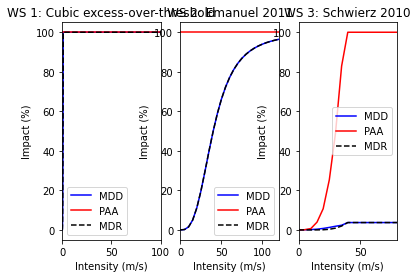

In [32]:
impf_set_uncal.plot()

In [40]:
#select climate models, used scenarios (historical, ssp585,...), impact functions and calibration type
modlist = modlist_ssp585 + modlist_allscen
modlist = modlist
impf_used = impf_namelist
scen_used= ['historical']
pastname = 'historical'
timeres='day'
nmems = 3
caltype = 'nocal'

In [41]:
##main calculation cell: iterative calibration
#Loop over impact functions, scenarios, models and model members
#Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
#Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.
stack = True
savehaz = False
saveimpmat = False
saveimpcsv = False
savestats = True
flt_imp = True #need to enables impact matrices
flt = 100E6
precision = 200E6
max_it = 20
step = 0.2

df_list = []
impf_keys = []

#param df
range_it = range(max_it)
metrics = ["error","param"]
itercol = [range_it,metrics]
col_idx = pd.MultiIndex.from_product(itercol,names=["iteration","result"])
iterrows = [modlist,impf_used]
row_idx = pd.MultiIndex.from_product(iterrows,names=["model","impf"])
param_df = pd.DataFrame(index=row_idx,columns=col_idx)
param_df_best = pd.DataFrame(index=row_idx,columns=["Nb it","best param","min error"])

for impfi in impf_used:
    
    # get impf_set 
    impf_set = impf_set_dict[impfi]
    for scen in scen_used:
        for modid, modname in enumerate(modlist):
            #read netcdf
            fn = make_fn([modname],bn,filetype=".nc")
            ncdf = xr.open_dataset(pathinvar+fn)
            ncdfw = ncdf[[pastname,scen]]
            latres, lonres = get_lat_lon_res(ncdf)
            latout = ncdf.lat
            lonout = ncdf.lon
            #select number of members to be considered
            if stack:
                nmems=1
            else:
                nmems = len(ncdf.member)
                
            #apply gust factor
            gust_ds = gst_fact*ncdfw
            
            # get names
            impf_namesht = impf_sht_names[impfi]
            pp_funcname = str(pp_func_dic[impfi]).split(" ")[1]
            savenamehaz = make_fn([pp_funcname],bn_proc)
            savenameimp = make_fn([impf_namesht,caltype],bn_proc)

            #iterate over the members
            for imem in range(nmems):
                #preprocess fields
                if stack:
                    mem_da = gust_ds
                else: 
                    mem_da = gust_ds.sel(member=imem)
            
                preprocess_func = pp_func_dic[impfi]
                gust_pp = preprocess_func(mem_da,qt,cutarea=cut,timeres=timeres,pastname=pastname,futname=scen,stack=stack)
                if scen != 'historical':
                    gust_pp_sel = gust_pp[scen]
                else:
                    gust_pp_sel = gust_pp
                
                #prepare hazards centroids
                haz = set_centroids(gust_pp_sel,stack=stack,timeres=timeres,plot=False)
                if impf_namesht == 'CubEOT':
                    max_int =  haz.intensity.max()
                    if max_int >= 1:
                        print("*"*100+'\n\n'+' '*25+'/!\ max_int = '+str(max_int)+' for model '+modname+'\n\n'+"*"*100)
                
                # deepcopy exposure before assigning centroids
                exp_sel = cp.deepcopy(exp)
                # Exposures: rename column and assign id
                if_id = 1 #take calibrated impf
                exp_sel.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
                exp_sel.gdf['impf_' + haz_type] = if_id
               
                #assign centroids
                dist_th = np.sqrt((latres*100)**2 + (lonres*100)**2)
                exp_sel.assign_centroids(haz,distance='euclidean',threshold=dist_th)
                exp_sel.check()
                
                #compute impacts
                start_time = timer()
                it=0
                param = 1
                impf_seti = tune_impf(impf_set,param,modname,plot=False)
                imp = Impact()
                imp.calc(exp_sel, impf_seti, haz, save_mat=saveimpmat) 
                
                aai_agg_flt = filter_imp(imp,flt)
                if aai_agg_flt==0:
                    while aai_agg_flt <= 0:
                        param = 1.01*param
                        imp.at_event = param*imp.at_event
                        aai_agg_flt = filter_imp(imp,flt)
                param_df.loc[(modname,impfi),(it,"error")] = aai_agg_flt-aai_agg_emdat
                param_df.loc[(modname,impfi),(it,"param")] = param
                
                #first guess
                best_param = aai_agg_emdat/aai_agg_flt
                min_dist = aai_agg_flt-aai_agg_emdat
                if (min_dist > 0):
                    new_param = best_param - step*best_param
                else:
                    new_param = best_param + step*best_param
                
                while ((abs(min_dist) >= precision) and it < max_it):
                    del imp
                    del impf_seti
                    it = it+1
                    #compute impacts
                    impf_seti = tune_impf(impf_set,new_param,modname,plot=False)
                    imp = Impact()
                    imp.calc(exp_sel, impf_seti, haz, save_mat=saveimpmat) 
                    #filter aai
                    aai_agg_flt = filter_imp(imp,flt)
                    #compute error
                    new_dist = aai_agg_flt-aai_agg_emdat
                    #write results
                    param_df.loc[(modname,impfi),(it,"error")] = new_dist
                    param_df.loc[(modname,impfi),(it,"param")] = new_param
                    
                    #prepare next step
                    if (abs(new_dist) < abs(min_dist)):
                        min_dist = new_dist
                        best_param = new_param
                    
                    old_param = new_param
                    
                    if (new_dist > 0):
                        new_param = old_param - step*old_param
                    else:
                        new_param = old_param + step*old_param
                
                param_df_best.loc[(modname,impfi),"min error"] = min_dist
                param_df_best.loc[(modname,impfi),"best param"] = best_param
                param_df_best.loc[(modname,impfi),"Nb it"] = it
                
                
                time_delta_past = timer() - start_time
                print('Iteration stopped after '+str(it)+' its and '+str(time_delta_past)+' s')
    
                

param_df = param_df.astype(np.float64)
param_df_best = param_df_best.astype(np.float64)

Iteration stopped after 3 its and 1.011489737778902 s
****************************************************************************************************

                         /!\ max_int = 1.3647537472836784 for model BCC-CSM2-MR

****************************************************************************************************
Iteration stopped after 3 its and 0.969008419662714 s
****************************************************************************************************

                         /!\ max_int = 1.055910093539173 for model CNRM-CM6-1-HR

****************************************************************************************************
Iteration stopped after 3 its and 0.8823710344731808 s
****************************************************************************************************

                         /!\ max_int = 1.4111661541904184 for model EC-Earth3-CC

************************************************************************************

In [42]:
pd.set_option("display.max_rows", None)
param_df_best

Nb it  best param     min error
model            impf                                                        
AWI-CM-1-1-MR    Cubic excess-over-threshold    3.0    0.003486  4.200098e+07
                 Emanuel 2011                   3.0    0.016035 -8.853918e+07
                 Schwierz 2010                  9.0   28.859366 -1.188350e+08
BCC-CSM2-MR      Cubic excess-over-threshold    3.0    0.004931  3.617231e+07
                 Emanuel 2011                   3.0    0.022474 -5.632794e+07
                 Schwierz 2010                 10.0   44.577749  6.470787e+07
CNRM-CM6-1-HR    Cubic excess-over-threshold    3.0    0.003006  3.944295e+07
                 Emanuel 2011                   3.0    0.013877 -7.327010e+07
                 Schwierz 2010                  3.0   14.494109  1.568326e+08
EC-Earth3-CC     Cubic excess-over-threshold    3.0    0.003948  7.161994e+07
                 Emanuel 2011                   3.0    0.017373 -4.576308e+07
                 Schwierz 2010                 10.0   27.862807  7.270009e+07
HadGEM3-GC31-LL  Cubic excess-over-threshold    3.0    0.002277  6.982680e+07
                 Emanuel 2011                   3.0    0.023149 -7.566934e+07
                 Schwierz 2010                 20.0   54.522934 -2.400669e+08
GISS-E2-1-G      Cubic excess-over-threshold    3.0    0.005217  2.780656e+07
                 Emanuel 2011                   3.0    0.028877 -1.258820e+08
                 Schwierz 2010                 18.0   82.215931  1.212867e+08
GFDL-CM4         Cubic excess-over-threshold    3.0    0.003259  7.381186e+07
                 Emanuel 2011                   3.0    0.019762 -1.872226e+07
                 Schwierz 2010                 19.0   43.206952  1.409650e+08
CMCC-CM2-SR5     Cubic excess-over-threshold    3.0    0.004796 -1.186036e+07
                 Emanuel 2011                   3.0    0.030140 -1.600052e+08
                 Schwierz 2010                 12.0   92.261480  1.609279e+08
CMCC-ESM2        Cubic excess-over-threshold    3.0    0.004561  4.233139e+07
                 Emanuel 2011                   3.0    0.026388 -1.273457e+08
                 Schwierz 2010                 13.0   70.778780 -1.051387e+08
HadGEM3-GC31-MM  Cubic excess-over-threshold    3.0    0.001928  1.081395e+08
                 Emanuel 2011                   3.0    0.017840 -3.461182e+07
                 Schwierz 2010                 10.0   36.875844  1.922590e+08
NESM3            Cubic excess-over-threshold    3.0    0.002413  7.014459e+07
                 Emanuel 2011                   3.0    0.014764 -9.769042e+07
                 Schwierz 2010                 12.0   30.082640  1.104457e+08
MPI-ESM1-2-HR    Cubic excess-over-threshold    3.0    0.003708  7.548162e+07
                 Emanuel 2011                   3.0    0.016528 -5.339803e+07
                 Schwierz 2010                  8.0   30.934471 -8.984054e+07
INM-CM4-8        Cubic excess-over-threshold    3.0    0.005055  4.629491e+07
                 Emanuel 2011                   3.0    0.027528 -1.099514e+08
                 Schwierz 2010                 17.0   69.546657  6.336619e+07
INM-CM5-0        Cubic excess-over-threshold    3.0    0.005272  6.310805e+06
                 Emanuel 2011                   3.0    0.030532 -1.009305e+08
                 Schwierz 2010                 14.0   69.399774  7.581607e+07
ACCESS-CM2       Cubic excess-over-threshold    3.0    0.001524  1.035614e+08
                 Emanuel 2011                   3.0    0.016803 -4.935603e+07
                 Schwierz 2010                  6.0   31.054916  9.448740e+07
CanESM5          Cubic excess-over-threshold    3.0    0.001365  1.613095e+08
                 Emanuel 2011                   3.0    0.008001  2.452045e+07
                 Schwierz 2010                  3.0    7.693907  9.819326e+07
CNRM-CM6-1       Cubic excess-over-threshold    3.0    0.005590  3.300822e+07
                 Emanuel 2011                   3.0    0.021403 -1.2

In [43]:
param_df_best["best param"].unstack()

impf,Cubic excess-over-threshold,Emanuel 2011,Schwierz 2010
model,,,
ACCESS-CM2,0.001524,0.016803,31.054916
ACCESS-ESM1-5,0.003382,0.026685,77.368903
AWI-CM-1-1-MR,0.003486,0.016035,28.859366
BCC-CSM2-MR,0.004931,0.022474,44.577749
CMCC-CM2-SR5,0.004796,0.030140,92.261480
CMCC-ESM2,0.004561,0.026388,70.778780
CNRM-CM6-1,0.005590,0.021403,45.982609
CNRM-CM6-1-HR,0.003006,0.013877,14.494109
CNRM-ESM2-1,0.004656,0.019432,41.380036


In [44]:
lst_bn = metvar+spaceres+["day"]+domain+season+["allmods"]
basenamemet = sep.join(lst_bn)
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)

caltype = "AAI_EMDAT_100mn"
calfn = make_fn(["cal","abs",caltype],basenamemet_proc,filetype=".csv")

In [45]:
calfn

'cal_abs_AAI_EMDAT_100mn_qt98pst_cutarea1E6_gst1-67_SWM_br_rg_day_EU_winE_allmods.csv'

In [46]:
idx = pd.IndexSlice
params_df = param_df_best["best param"].unstack()
params_df.to_csv(pathcal+calfn)

In [47]:
pd.reset_option('display.max_rows')

In [100]:
#plot calibrated functions
caltype = "AAI_EMDAT_100mn"
calfn = make_fn(["cal",caltype],basenamemet_proc,filetype=".csv")
paramspath = pathcal+calfn
nfcs = len(impf_used)
nmods = len(modlist)
#fig = plt.figure(figsize=(5*nmods,10*nfcs))
#axs = fig.subplots(nrows=nmods,ncols=nfcs*2)
impf_used = impf_namelist
for imod, modname in enumerate(modlist):
    #axrow = axs[imod]
    for impfi,impf in enumerate(impf_used):
        impf_namesht = impf_sht_names[impf]
        impf_set = impf_dict[impf]
        param = pd.read_csv(paramspath,header=[0],index_col=0).loc[modname,impf]
        impf_set = tune_impf(impf_set,param,modname,plot=False)
        #aximpf = axrow[impfi:impfi+1]
        axs = impf_set.plot()
        for axi in axs:
            if impf_namesht == 'CubEOT':
                axi.set_xlabel('Normalized intensity (-)')
                axi.set_xlim((0,5))
                
        #if impf_namesht != 'Sw2010':
        #    ax[1].set_ylim((0,20))


TypeError: tune_impf() missing 1 required positional argument: 'fun_id'

In [49]:
pd.read_csv(paramspath,header=[0],index_col=0).loc[modname,impf]

0.0031209694259412

In [63]:
axs

<AxesSubplot:>

In [61]:
axs

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [51]:
impf_sht_names

{'Cubic excess-over-threshold': 'CubEOT',
 'Scaled sigmoid': 'ScSig',
 'Emanuel 2011': 'Em2011',
 'Welker 2021': 'Wk2021',
 'Schwierz 2010': 'Sw2010'}

In [48]:
axrow.flatten()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [43]:
impf_set.plot??

Signature: impf_set.plot(haz_type=None, fun_id=None, axis=None, **kwargs)
Source:   
    def plot(self, haz_type=None, fun_id=None, axis=None, **kwargs):
        """Plot impact functions of selected hazard (all if not provided) and
        selected function id (all if not provided).

        Parameters
        ----------
        haz_type : str, optional
            hazard type
        fun_id : int, optional
            id of the function

        Returns
        -------
        matplotlib.axes._subplots.AxesSubplot
        """
        num_plts = self.size(haz_type, fun_id)
        num_row, num_col = u_plot._get_row_col_size(num_plts)
        # Select all hazard types to plot
        if haz_type is not None:
            hazards = [haz_type]
        else:
            hazards = self._data.keys()

        if not axis:
            _, axis = plt.subplots(num_row, num_col)
        if num_plts > 1:
            axes = axis.flatten()
        else:
            axes = [axis]

        i_axis = 0
  

In [39]:
axrow

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

## Compare the 2 calibration

In [119]:
## Get params values
caltype = "AAI_EMDAT"
processings1 = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(1E6,'.0E').replace("+0",''),"gst1-67"]
processings2 = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(2E6,'.0E').replace("+0",''),"gst1-67"]

basenamemet_proc1 = make_fn(processings1,basenamemet)
basenamemet_proc2 = make_fn(processings2,basenamemet)

# 1E6

calfn1 = make_fn(["cal",caltype],basenamemet_proc1,filetype=".csv")
paramspath1 = pathcal+calfn1
param_proc1 = pd.read_csv(paramspath1,header=[0,1,2],index_col=0)
# 2E6
calfn2 = make_fn(["cal",caltype],basenamemet_proc2,filetype=".csv")
paramspath2 = pathcal+calfn2
param_proc2 = pd.read_csv(paramspath2,header=[0,1,2],index_col=0)

In [123]:
param_diff = param_proc1.sub(param_proc2)
param_diff_rel = param_diff.div(param_proc1)*100

In [125]:
param_diff_rel
param_diff_rel.columns = param_diff_rel.columns.droplevel(1)
def style_10high(v, props=''):
    return props if v > 5 else None
param_diff_rel.index.name = 'Change in parameter value (%)'
s2 = param_diff_rel.style.applymap(style_10high, props='color:red;')
s2.format('{:.2f}')

Impf,CubEOT,Em2011,Sw2010
metric,AAI_agg,AAI_agg,AAI_agg
Change in parameter value (%),,,
CanESM5,15.54,48.42,53.19
CNRM-CM6-1,-64.09,-46.75,-39.82
CNRM-ESM2-1,-65.31,-57.76,-52.11
EC-Earth3-Veg,-96.26,-73.37,-64.62
EC-Earth3-Veg-LR,-65.97,-55.56,-47.72
IPSL-CM6A-LR,16.52,-0.84,11.49
MIROC-ES2L,39.57,45.60,52.92
UKESM1-0-LL,-50.34,-24.98,-25.19
